## Carga de librerias y dataset

Las librerias necesarias para este notebook serán las siguientes importadas:

In [1]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.cluster import KMeans

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

Se renombra a las columnas en un formato mas comodo de manejar.

# Análisis Exploratorio

## ¿Como es la distribución de los valores adquisitivos?

Primero detallemos cuantas personas han respondido la encuesta

In [4]:
print("Esta encuesta ha sido respondida por:", len(df), "personas")

Esta encuesta ha sido respondida por: 32561 personas


Veamos en prinicipio la cantidad y la proporción de personas que han declarado tener alto u bajo valor adqusitivo.

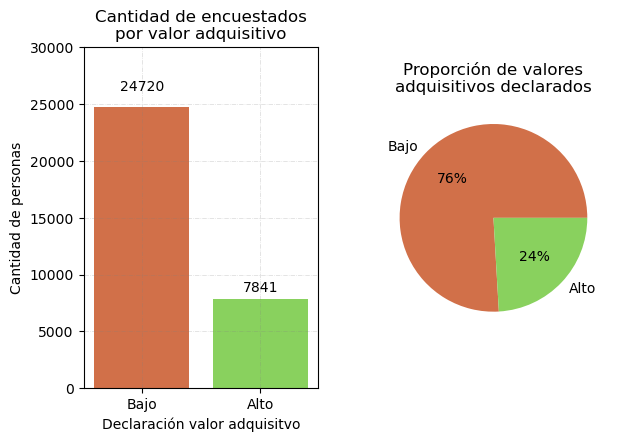

In [5]:
fig, axes = plt.subplots(ncols = 2, dpi=100)
fig.tight_layout()

axes_0 = axes[0].bar(['Bajo', 'Alto'], df.tiene_alto_valor_adquisitivo.value_counts().values,  color=['#D17049',"#89D15E"])

axes[1].pie(df.tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
axes[1].set_title("Proporción de valores\nadquisitivos declarados")

axes[0].set_ylabel("Cantidad de personas")
axes[0].set_xlabel("Declaración valor adquisitvo")
axes[0].set_title("Cantidad de encuestados\npor valor adquisitivo")                  
                  
for rect in axes_0:
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')
        

axes[0].set_yticks(np.arange(0,35000, 5000))
axes[0].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Podemos observar que solo un 25% (7210 personas) han declarado tener alto valor adquisitivo. A prori esta variable por si sola no nos aporta mucho.

¿JUSTIFICACIÓN CORRECTA?: *si la proporción era maso menos igual,quizás algo podemos decir, pero no fue el caso*

## ¿Cómo es la distribución de los Barrios?

Para responder ésta pregunta primero veamos cuantos son los barrios que han sido cargados


In [6]:
print('Cantidad barrios únicos: ', df.barrio.value_counts().nunique())

Cantidad barrios únicos:  37


Una altisima cantidad de barrios ingresados, es decir, una alta cardinalidad para ésta feature.

Veamos la cantidad de encuestados por barrio

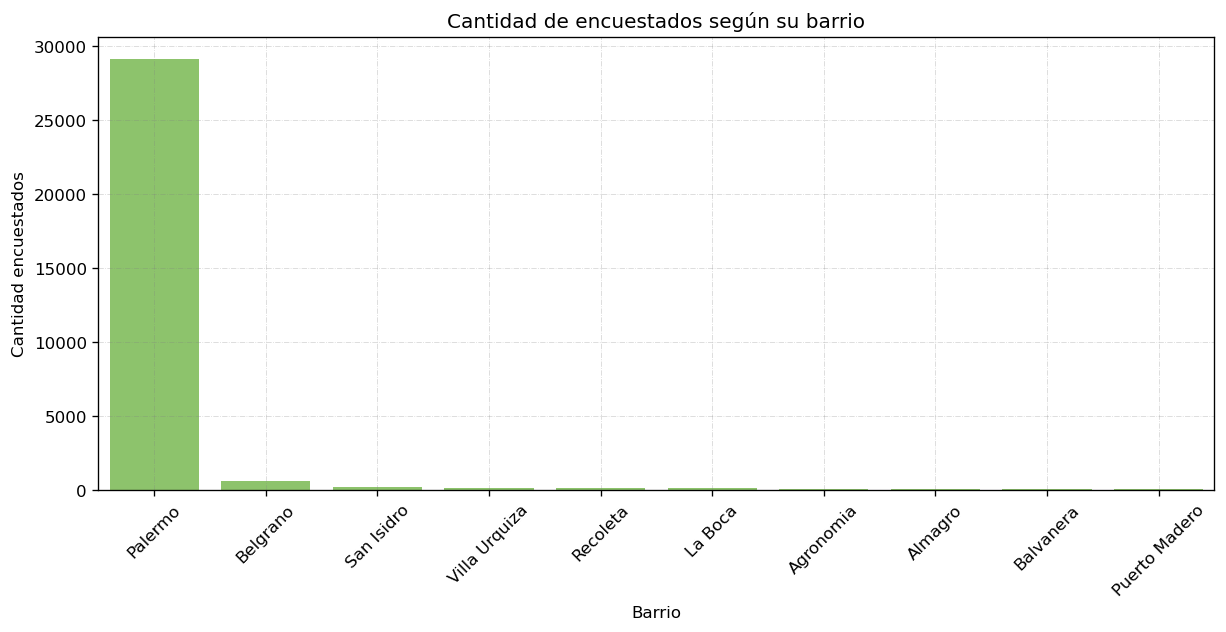

In [7]:
cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
sns.countplot(
    x="barrio",
    data=df,
    order=df["barrio"].value_counts().iloc[:cantidad_barrios_visualizados].index,
    color='#89D15E',
)

plt.ylabel("Cantidad encuestados")
plt.xlabel("Barrio")
plt.title("Cantidad de encuestados según su barrio")
plt.xticks(rotation=45)

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Lo cual se peude notar una altisima cantidad de encuestados provenientes de Palermo, por ende no podemos decir mucho a priori. Es mas, notar que solo graficamos 10 barrios de los 37 posibles que hay, en orden descendiente.

Si nos guiamos con proporciones

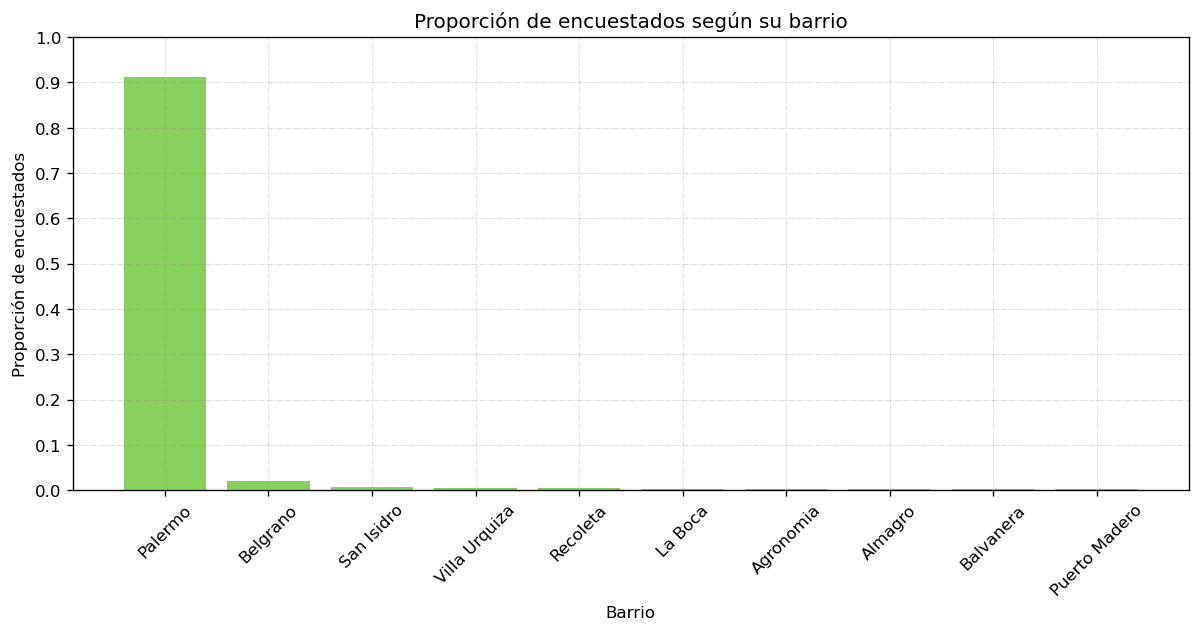

In [8]:
cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
barrios = (
    df['barrio']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
)
ax = plt.bar(barrios.iloc[:cantidad_barrios_visualizados].index, barrios.iloc[:cantidad_barrios_visualizados].values, color = '#89D15E')

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.ylabel("Proporción de encuestados")
plt.xlabel("Barrio")
plt.title("Proporción de encuestados según su barrio")
plt.xticks(rotation=45)
plt.yticks(np.arange(0,1.1, 0.1))
plt.show()

De la misma forma, era evidente observar que casi un 90% de las personas que fueron encuestadas fueron de Palermo y, en las demás comunas de la ciudad no llega ni al 1% de encuestados.

Podriamos averiguar la cantidad de personas en Palermo respecto si tienen alto nivel adquisito o no

### ¿En Palermo, hay inidicios de tener alto valor adquisitivo?

Teniendo en cuenta que Palermo es el barrio con mayor proporción de personas, preguntemosnos algo respecto valor adquisitivo

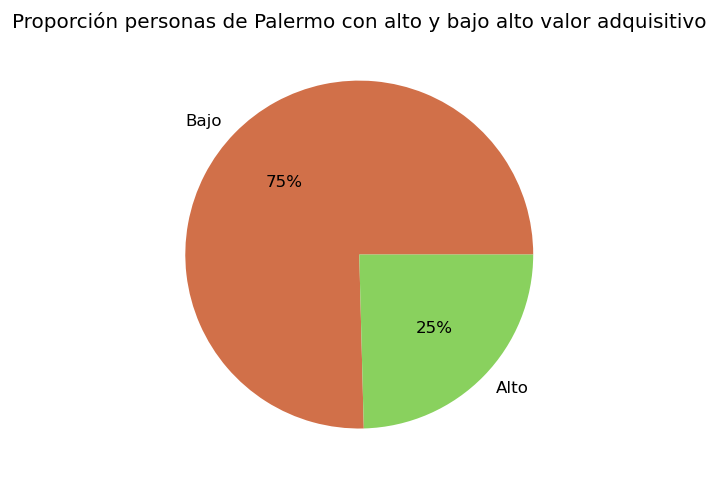

In [9]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.title('Proporción personas de Palermo con alto y bajo alto valor adquisitivo')
plt.pie(df[df.barrio == 'Palermo'].tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Es decir un 25% de las personas que habitan en la comuna de Palermo de CABA tienen un alto nivel adquisitivo. Pero a prori no nos dice mucha información ni responde nuestra pregunta. Quizás nos podrá ser interesante para futuras relaciones entre diferentes features.

Es conclusión si respondemos a la pregunta inicial que nos realizamos *"¿Cómo es la distribución de los Barrios?"*
Vimos que es una distribución poco equitativa y que a prori no nos muestra mucha ifnormación ni podemos buscar algun patón relacionandolos con el valor adquisitivo.

Tambien vimos la relacion con el barrio Palermo, y concluimos que vivir en Palermo no implica tener declarado un alto valor adquisitivo.


## ¿Hay relación entre la Edad y el Genero?

Primero preguntemosno y veamos cómo se distribuyen dichas variables

### ¿Cómo se distribuye los generos?

Veamos con grafico simple la cantidades de generos que han respondido la encuesta

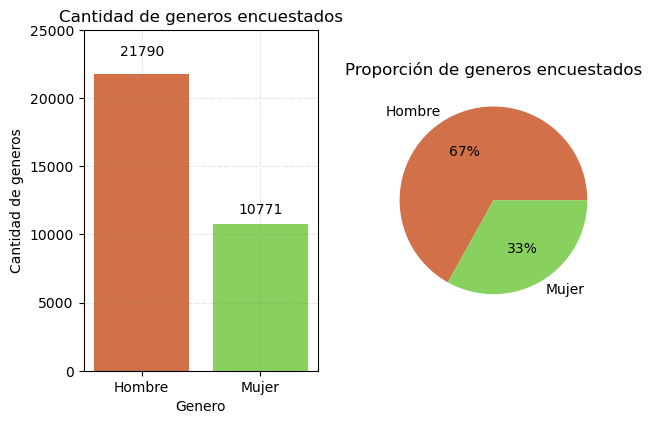

In [10]:
fig, axes = plt.subplots(ncols = 2, dpi=100)
fig.tight_layout()

axes_0 = axes[0].bar(['Hombre', 'Mujer'], df.genero.value_counts().values,  color=['#D17049',"#89D15E"])

axes[1].pie(df.genero.value_counts().values, labels= ['Hombre', 'Mujer'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
axes[1].set_title("Proporción de generos encuestados")

axes[0].set_ylabel("Cantidad de generos")
axes[0].set_xlabel("Genero")
axes[0].set_title("Cantidad de generos encuestados")

for rect in axes_0:
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')
        

axes[0].set_yticks(np.arange(0,30000, 5000))
axes[0].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Hay una un 66% de hombres encuestados que de mujeres. A prori podemos suponer que la encuesta le llegaron en mano a mas hombres que mujeres, aunque tambien nos habre otro escenario mas de posibilidades: quizás a las mujeres no les interesó responder la encuesta.

Veamos como se distribuye la edad en la encuesta

### ¿Hay missings en la edad?

Antes de analizar, nos preguntamos por los missings, chequemos las variables numericas del a misma

In [11]:
(df.edad < 0).any()

False

Es decir, no hay ninguna edad incongruente. Veamos la cantidad de missings

In [12]:
df.edad.isna().any()

False

Tampoco hay missings o valores **NaN**, prosegumos entonces con el analisis de las edades

### ¿Y cómo es la distribución de la edad?

Veamos primero las cantiades de edades unicas que tenemos:

In [13]:
print("Cantidad de edades unicas encuestadas son", df.edad.nunique())

Cantidad de edades unicas encuestadas son 73


Es decir, clarametne una variable continua, con alta cardinalidad. Veamos esto en graficos

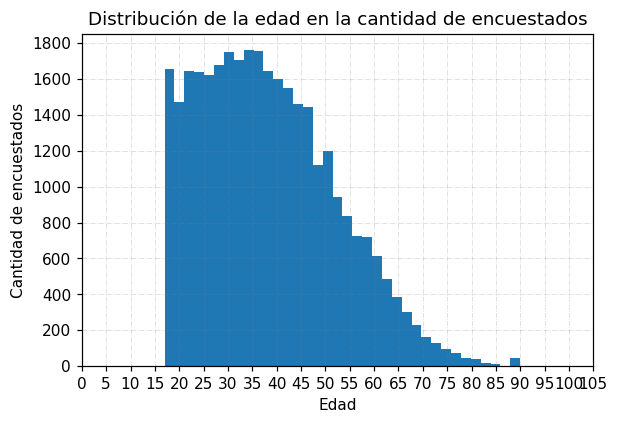

In [14]:
plt.figure(dpi=110)
bins_deseados = int(df.edad.nunique()/2)
plt.hist(df.edad, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad")
plt.xticks(np.arange(0,110, 5))
plt.yticks(np.arange(0,2000, 200))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Hay un amplio rango de edades, principalmente hay una mayor concentracion de personas que respondieron la encuesta entre 25 y 50 años aporximadamente.

Pero notamos que puede ser muy confuso este grafico, buscaremos discretizar por grupos de edades para ver mas claro lo que queremos transmitir

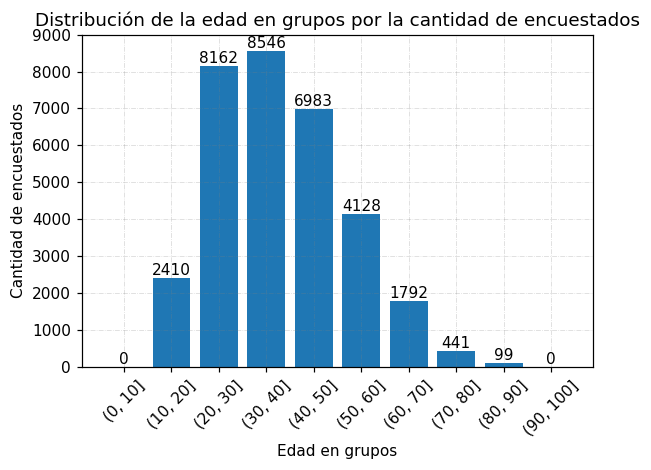

In [15]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(0,110,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

for rect in ploted:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.title("Distribución de la edad en grupos por la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad en grupos")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,9500, 1000))
plt.show()

En conclusión podemos observar tres grupos mayoritarios que respondieron la encuesta. En este caso de 20 a 50 años fueron los mas propensos.

### Veamos entonces la relación entre Edad y Genero 

Ahora que ya tenemos un panorama general de dichas variables, veamos la cantidad de encuestados por edad y genero.

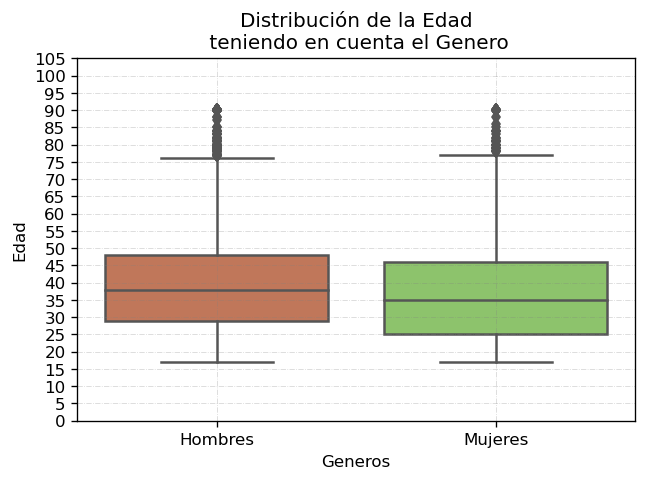

In [16]:
plt.figure(dpi=120)
plt.title("Distribución de la Edad\n teniendo en cuenta el Genero")
sns.boxplot(
    data=df,
    y='edad',
    x='genero',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Edad")
plt.xlabel("Generos")
plt.xticks([False, True], ["Hombres", "Mujeres"])
plt.yticks(np.arange(0,110, 5))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

El cual se puede observar que la media de edad de ambos grupos encuestados no difiere tanto.

Es decir, que se mantiene la proproción de edades encuestados muy levemente. La diferencia a lo sumo serian 3 o 4 años, en otras palabras: hay mas jovenes mujeres que respondieron la encuesta en vez hombres, pero es una diferencia muy leve.
 

### ¿Hay igualdad de Genero en los valores adquisitivos declarados?

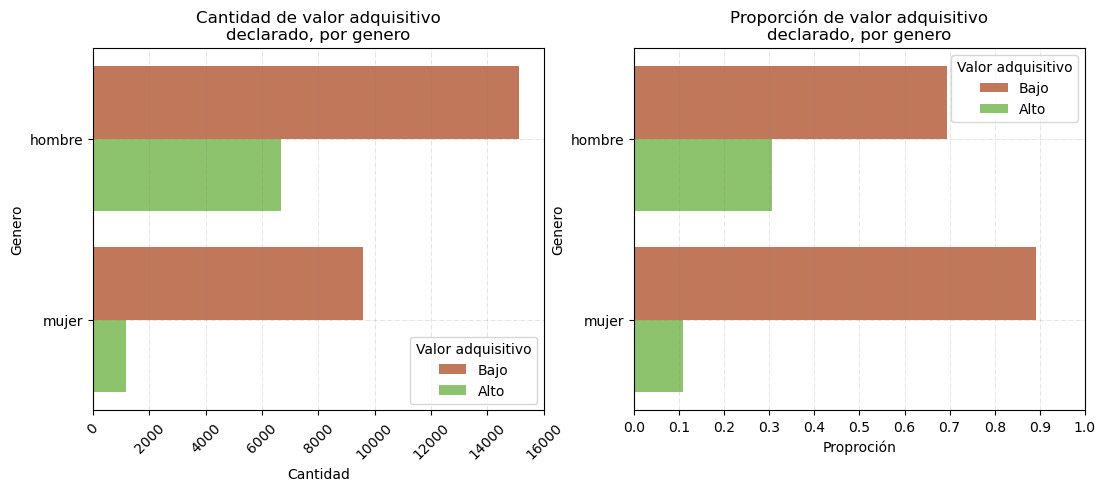

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
colors = ['#D17049', "#89D15E"]

ploted_cero = sns.countplot(data=df, y='genero', hue='tiene_alto_valor_adquisitivo', ax=axes[0] , palette=colors)
axes[0].set_title("Cantidad de valor adquisitivo\ndeclarado, por genero")
axes[0].set_xlabel("Cantidad")
axes[0].set_xticks(np.arange(0,18000, 2000))
axes[0].tick_params('x',labelrotation=45)

ploted_one = sns.barplot(
    data=df.groupby("genero")
    .tiene_alto_valor_adquisitivo.value_counts(normalize=True)
    .rename("Cantidades")
    .reset_index(),
    y='genero',
    x="Cantidades",
    hue='tiene_alto_valor_adquisitivo',
    ax=axes[1],
    palette=colors,
)
axes[1].set_xlabel("Proproción")
axes[1].set_title("Proporción de valor adquisitivo\ndeclarado, por genero")
axes[1].set_xticks(np.arange(0,1.1, 0.1))

for plot in [ploted_cero, ploted_one]:
    leg = plot.get_legend()
    leg.set_title("Valor adquisitivo")
    labs = leg.texts
    labs[0].set_text("Bajo")
    labs[1].set_text("Alto")
    plot.set_ylabel("Genero")
    plot.set_ylabel("Genero")
    plot.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Como podemos observar, y respondiendo a nuestra pregunta, no es equitativo la declaración del valor adquisitivo.

Hay una mayor proporción de hombres que declaran tener alto valor adquisitivo a comparación de las mujeres. Y si hablamos en cantidades, solo casi mil mujeres contra seismil quinientas de hombres han declarado tener altos ingresos.

**DEBATIR JUSTIFICACIÓN:**

**¿En conclusión, no parece ser una variable muy interesante?** por el bajo porcentaje que hay en la declaración de alto valor adquisitivo. Ademas teniendo en cuenta que, como ya vimos, habia un 66% de hombres encuestados, y el resto de mujeres lo cual se podria justificar esa diferencia de porcentaje de alto valor adquisitivo.

### FALTA JUSTIFICAR: ¿Hay un rango de edades influyente en cada genero que dé indicios de tener alto valor adquisitivo?

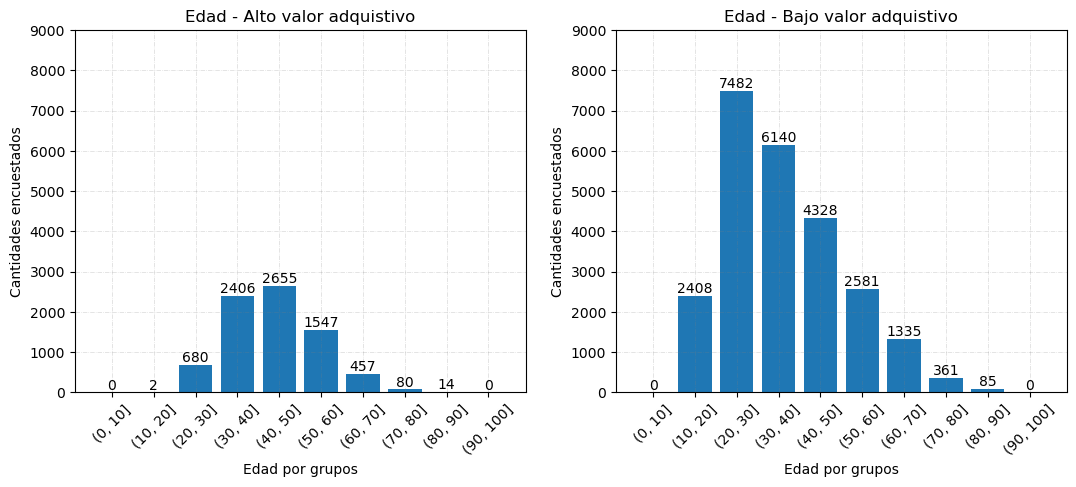

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_alto_valor = df[df.tiene_alto_valor_adquisitivo == 1]
df_bajo_valor = df[df.tiene_alto_valor_adquisitivo == 0]

rango_edades =  np.arange(0,110,10)
cantidad_Altos_en_rango = pd.Series(pd.cut(df_alto_valor['edad'], bins = rango_edades).value_counts()).sort_index()
cantidad_Bajos_en_rango = pd.Series(pd.cut(df_bajo_valor['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = axes[0].bar(cantidad_Altos_en_rango.index.astype(str), cantidad_Altos_en_rango.values)
ploted2 = axes[1].bar(cantidad_Bajos_en_rango.index.astype(str), cantidad_Bajos_en_rango.values)

for plot in [(ploted,axes[0]), (ploted2,axes[1])]:
    for rect in plot[0]:
        height = rect.get_height()
        plot[1].text(rect.get_x() + rect.get_width()/2., height, 
                '%d' % int(height),
                ha='center', va='bottom')
        
    plot[1].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
    plot[1].tick_params('x',labelrotation=45)
    plot[1].set_ylabel("Cantidades encuestados")
    plot[1].set_xlabel("Edad por grupos")
    plot[1].set_yticks(np.arange(0,9500, 1000))
    
axes[0].set_title("Edad - Alto valor adquistivo")
axes[1].set_title("Edad - Bajo valor adquistivo")
  
plt.show()

Al parecer... de 40 a 50. Pero hay que ir variando los grupos de edades!!!

**Falta justificar bien esto despues!!**

** estaria piola mostrarlo en porcentual creo

value_counts(normalize=True) 